In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

In [455]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

# Original data distribution

In [524]:
prop_file = "../data/cgcnn_junwen_july_3_kdist/id_prop.csv"

In [525]:
df=pd.read_csv(prop_file,header=None)

In [526]:
min(df[1].values), max(df[1].values)

(np.float64(0.1198039151785822), np.float64(0.9996802858112204))

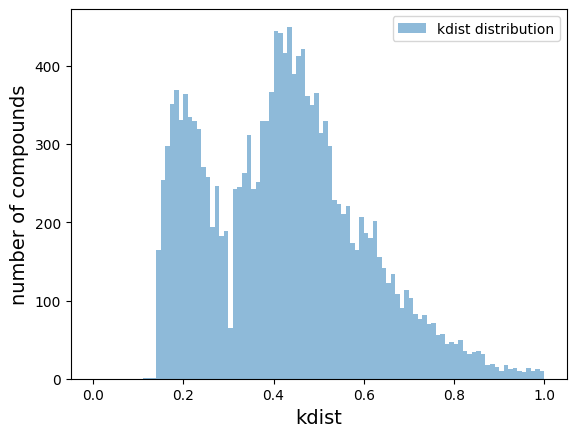

In [528]:
plt.hist(df[1].values, range=(0,1), bins=100, alpha=0.5, label='kdist distribution')
plt.xlabel('kdist', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.legend()
plt.show()

# Dummy model

In [460]:
c_opt=np.float64(0.1954954371489131)

# CGCNN, loss L2Robust

In [555]:
output_file = "../output/cgcnn/cgcnn_basic_l2robust_regularization.csv"

In [556]:
df=pd.read_csv(output_file)

In [557]:
df.head(3)

,Unnamed: 0,id,truth_scaled,prediction0,logstd0,avg_prediction_scaled,prediction,truth
0,0,2678,0.381003,0.519933,0.121565,0.519933,0.519933,0.381003
1,1,3919,0.247393,0.201259,0.058389,0.201259,0.201259,0.247393
2,2,828,0.545084,0.464279,0.099469,0.464279,0.464279,0.545084


In [558]:
std = np.exp(df['logstd0'].values)

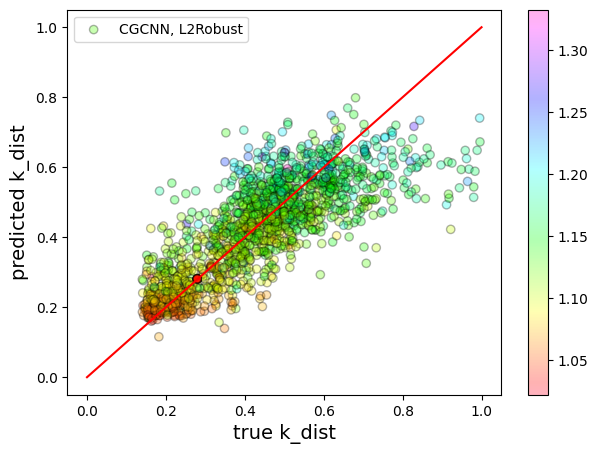

In [559]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, df['prediction'].values, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, L2Robust')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

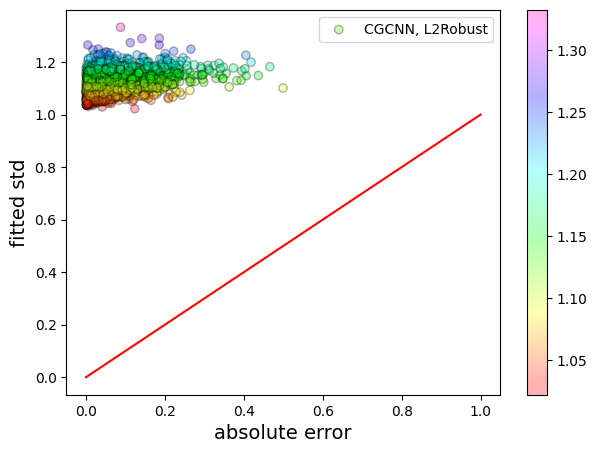

In [466]:
abs_errors=np.abs(df['truth'].values - df['prediction'].values)
scaled_std = std

plt.figure(figsize=(7,5))
sc=plt.scatter(abs_errors, scaled_std, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, L2Robust')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('absolute error', fontsize =14)
plt.ylabel('fitted std', fontsize = 14)
plt.legend()
plt.show()

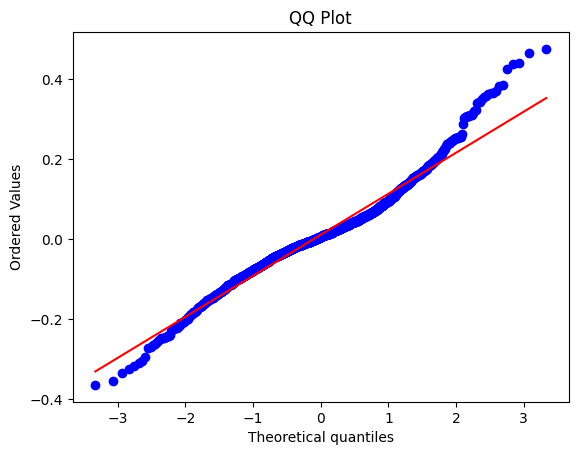

In [467]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# residuals: a numpy array or list of your model residuals
stats.probplot(errors, dist="norm", plot=plt)  # change "norm" to "laplace" or "t" if needed
plt.title("QQ Plot")
plt.show()

### Let's do imitation of quantiles

In [332]:
from scipy import stats

In [333]:
test_bins=np.linspace(0.01,0.99,19)
test_bin_values=np.zeros(len(test_bins))
for jbin,x in enumerate(test_bins):
    test_covered=0
    for i in range(len(std)):
        x1,x2=stats.norm.interval(x, loc=df['prediction'].values[i], scale=std[i])
        if(df['truth'].values[i]>x1 and df['truth'].values[i]<x2):
            test_covered+=1
    test_bin_values[jbin]=test_covered/len(std)

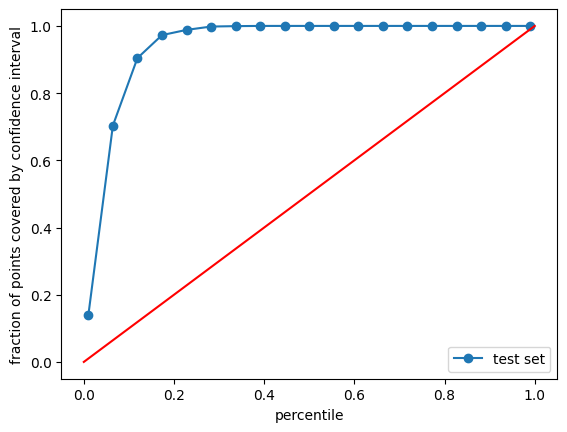

In [334]:
import matplotlib.pyplot as plt
plt.plot(test_bins,test_bin_values,'-o',label='test set')
plt.plot([0,1],[0,1],color='red')
plt.xlabel('percentile')
plt.ylabel('fraction of points covered by confidence interval')
plt.legend()
plt.show()

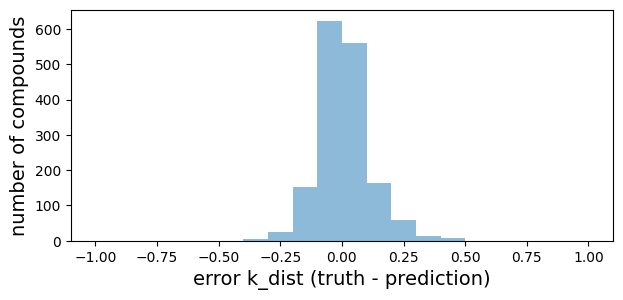

In [335]:
errors=df['truth'].values - df['prediction'].values

plt.figure(figsize=(7,3))
plt.hist(errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

In [336]:
shifted_predictions=[]
for i in range(len(df)):
    value=stats.norm.interval(0.1, loc=df['prediction'].values[i], scale=std[i])[0]
    if(value<0.02):
        shifted_predictions.append(0.02)
    else:
        shifted_predictions.append(value)

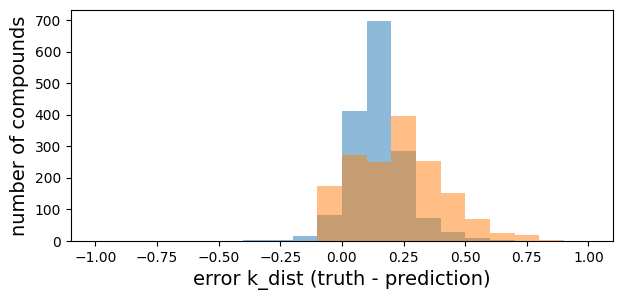

In [392]:
shifted_errors=df['truth'].values - shifted_predictions
dummy_errors=df['truth'].values-c_opt

plt.figure(figsize=(7,3))
plt.hist(shifted_errors, range=(-1,1), bins=20, alpha=0.5)
plt.hist(dummy_errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

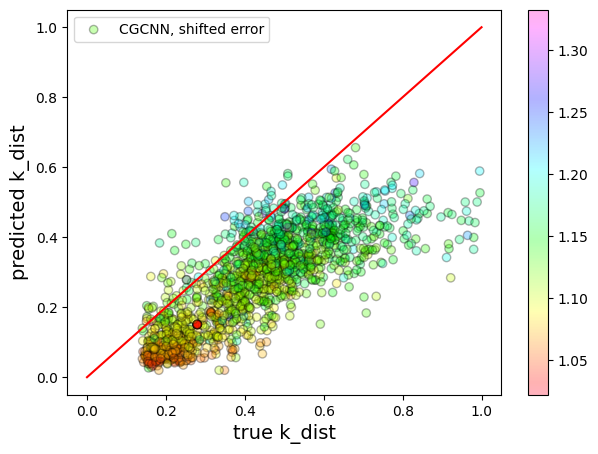

In [338]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, shifted_predictions, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, shifted error')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

In [393]:
np.sum([shifted_errors<0]), np.sum([shifted_errors<0])/len(shifted_errors), np.sum([dummy_errors<0]), np.sum([dummy_errors<0])/len(dummy_errors)

(np.int64(102),
 np.float64(0.06339341205717837),
 np.int64(173),
 np.float64(0.10752019888129273))

In [396]:
mse = mean_squared_error(df['truth'].values, shifted_predictions)
mae = mean_absolute_error(df['truth'].values, shifted_predictions)
mape = mean_absolute_percentage_error(df['truth'].values, shifted_predictions)
r2 = r2_score(df['truth'].values, shifted_predictions)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.1510637925405066
Test set MAPE: 0.3765864805422647
Test set MSE: 0.03155050464410264
Test set R2 score: -0.03279426081312353


In [397]:
mse = mean_squared_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mae = mean_absolute_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mape = mean_absolute_percentage_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
r2 = r2_score(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.2328592252025623
Test set MAPE: 0.46833731075132523
Test set MSE: 0.08241461457552567
Test set R2 score: -1.6978123456620682


# CGCNN, L1Robust

In [440]:
output_file = "../output/cgcnn/cgcnn_basic_l1robust.csv"

In [441]:
df=pd.read_csv(output_file)

In [442]:
df.head(3)

,Unnamed: 0,id,truth_scaled,prediction0,logstd0,avg_prediction_scaled,prediction,truth
0,0,2678,0.381003,0.571695,0.118293,0.571695,0.571695,0.381003
1,1,3919,0.247393,0.190240,0.032365,0.190240,0.190240,0.247393
2,2,828,0.545084,0.522630,0.082729,0.522630,0.522630,0.545084


In [443]:
std = np.exp(df['logstd0'].values)

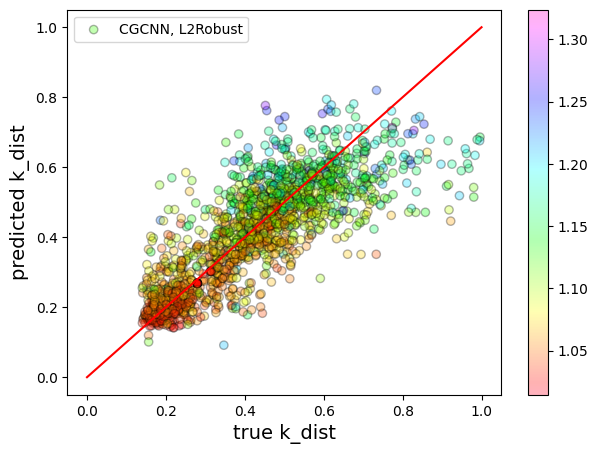

In [444]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, df['prediction'].values, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, L2Robust')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

In [445]:
from scipy import stats

test_bins=np.linspace(0.01,0.99,19)
test_bin_values=np.zeros(len(test_bins))
for jbin,x in enumerate(test_bins):
    test_covered=0
    for i in range(len(std)):
        scale = std[i] / np.sqrt(2)
        loc = df['prediction'].values[i]
        x1, x2 = stats.laplace.interval(x, loc=loc, scale=scale)
        if x1 < df['truth'].values[i] < x2:
            test_covered += 1
    test_bin_values[jbin] = test_covered / len(std)

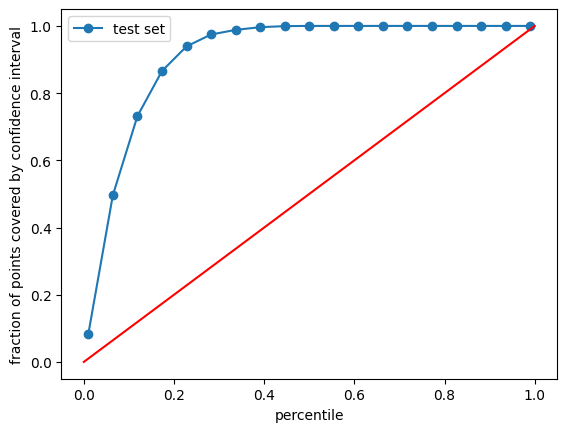

In [446]:
import matplotlib.pyplot as plt
plt.plot(test_bins,test_bin_values,'-o',label='test set')
plt.plot([0,1],[0,1],color='red')
plt.xlabel('percentile')
plt.ylabel('fraction of points covered by confidence interval')
plt.legend()
plt.show()

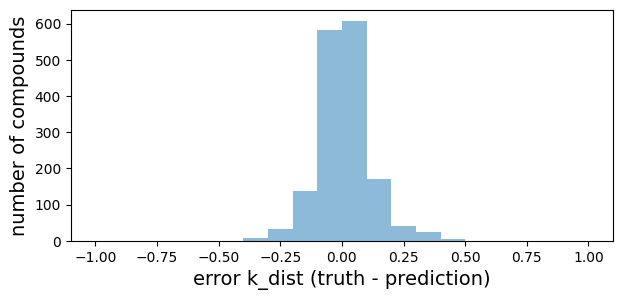

In [447]:
errors=df['truth'].values - df['prediction'].values
dummy_errors=df['truth'].values-c_opt

plt.figure(figsize=(7,3))
plt.hist(errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

In [448]:
shifted_predictions=[]
for i in range(len(df)):
    value=stats.laplace.interval(0.1, loc=df['prediction'].values[i], scale=std[i])[0]
    if(value<0.02):
        shifted_predictions.append(0.02)
    else:
        shifted_predictions.append(value)

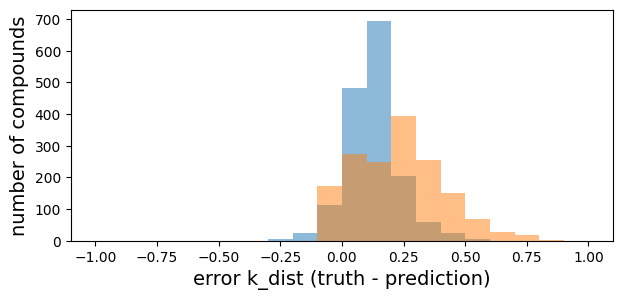

In [449]:
shifted_errors=df['truth'].values - shifted_predictions
dummy_errors=df['truth'].values-c_opt

plt.figure(figsize=(7,3))
plt.hist(shifted_errors, range=(-1,1), bins=20, alpha=0.5)
plt.hist(dummy_errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

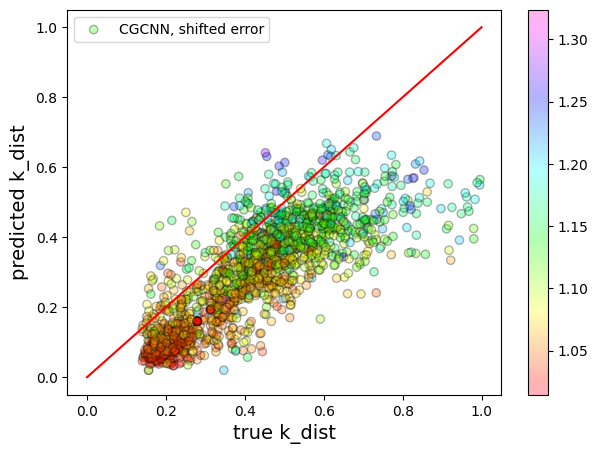

In [119]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, shifted_predictions, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, shifted error')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

In [450]:
np.sum([shifted_errors<0]), np.sum([shifted_errors<0])/len(shifted_errors), np.sum([dummy_errors<0]), np.sum([dummy_errors<0])/len(dummy_errors)

(np.int64(140),
 np.float64(0.0870105655686762),
 np.int64(173),
 np.float64(0.10752019888129273))

In [452]:
mse = mean_squared_error(df['truth'].values, shifted_predictions)
mae = mean_absolute_error(df['truth'].values, shifted_predictions)
mape = mean_absolute_percentage_error(df['truth'].values, shifted_predictions)
r2 = r2_score(df['truth'].values,shifted_predictions)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.13614918220094724
Test set MAPE: 0.342497680915025
Test set MSE: 0.02671389243611275
Test set R2 score: 0.1255304755591785


In [453]:
mse = mean_squared_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mae = mean_absolute_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mape = mean_absolute_percentage_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
r2 = r2_score(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.2328592252025623
Test set MAPE: 0.46833731075132523
Test set MSE: 0.08241461457552567
Test set R2 score: -1.6978123456620682


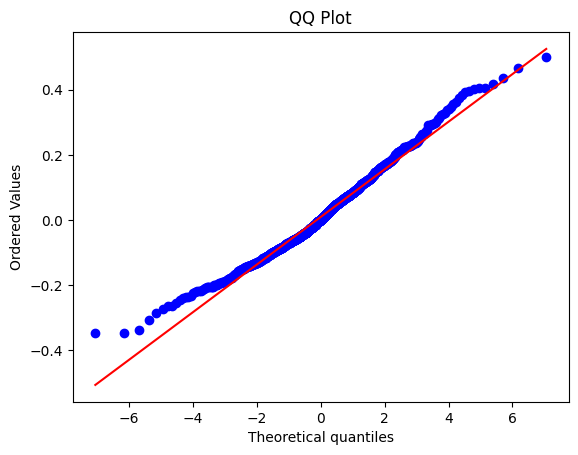

In [340]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# residuals: a numpy array or list of your model residuals
stats.probplot(errors, dist="laplace", plot=plt)  # change "norm" to "laplace" or "t" if needed
plt.title("QQ Plot")
plt.show()

# CGCNN, Student_nu3

In [167]:
output_file = "../output/cgcnn/cgcnn_basic_studentnu3.csv"

In [168]:
df=pd.read_csv(output_file)

In [169]:
df.head(3)

,Unnamed: 0,id,truth_scaled,prediction0,logstd0,avg_prediction_scaled,prediction,truth
0,0,2678,0.381003,0.546274,0.090354,0.546274,0.546274,0.381003
1,1,3919,0.247393,0.199173,0.015478,0.199173,0.199173,0.247393
2,2,828,0.545084,0.497796,0.075578,0.497796,0.497796,0.545084


In [170]:
std = np.exp(df['logstd0'].values)

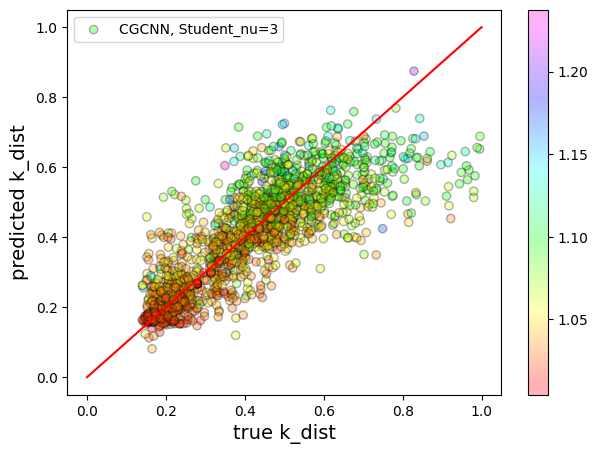

In [171]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, df['prediction'].values, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, Student_nu=3')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

In [172]:
from scipy import stats

test_bins=np.linspace(0.01,0.99,19)
test_bin_values=np.zeros(len(test_bins))
for jbin,x in enumerate(test_bins):
    test_covered=0
    for i in range(len(std)):
        scale = std[i] 
        loc = df['prediction'].values[i]
        x1, x2 = stats.t.interval(x, df=3, loc=loc, scale=scale)
        if x1 < df['truth'].values[i] < x2:
            test_covered += 1
    test_bin_values[jbin] = test_covered / len(std)

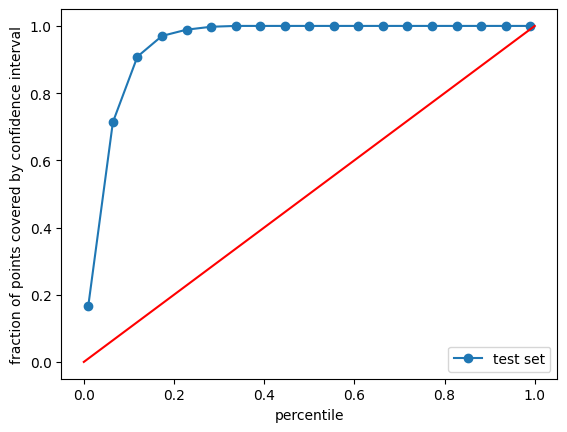

In [173]:
import matplotlib.pyplot as plt
plt.plot(test_bins,test_bin_values,'-o',label='test set')
plt.plot([0,1],[0,1],color='red')
plt.xlabel('percentile')
plt.ylabel('fraction of points covered by confidence interval')
plt.legend()
plt.show()

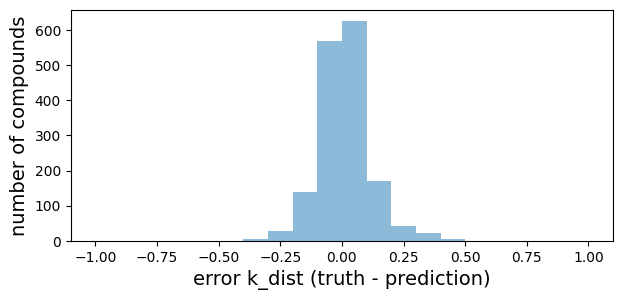

In [175]:
errors=df['truth'].values - df['prediction'].values

plt.figure(figsize=(7,3))
plt.hist(errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

In [176]:
shifted_predictions=[]
for i in range(len(df)):
    value=stats.t.interval(0.1, df=3, loc=df['prediction'].values[i], scale=std[i])[0]
    if(value<0.02):
        shifted_predictions.append(0.02)
    else:
        shifted_predictions.append(value)

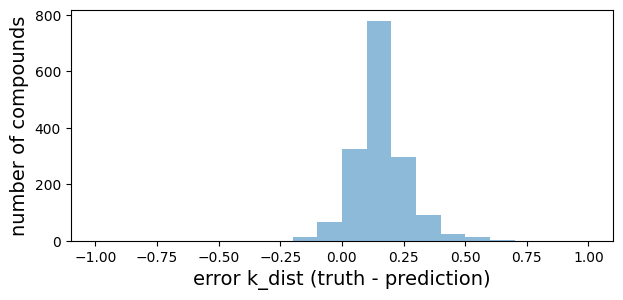

In [177]:
shifted_errors=df['truth'].values - shifted_predictions

plt.figure(figsize=(7,3))
plt.hist(shifted_errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

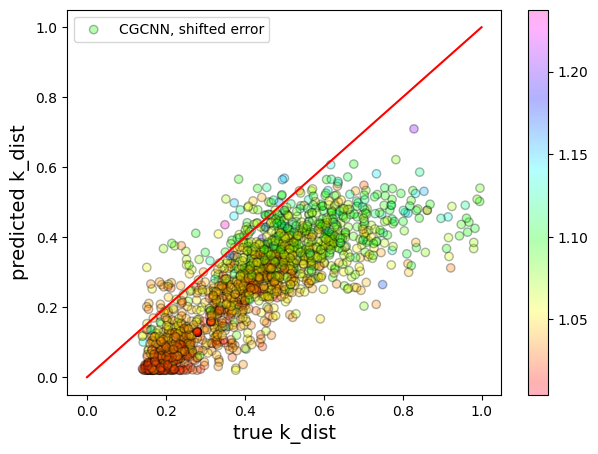

In [178]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, shifted_predictions, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, shifted error')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# residuals: a numpy array or list of your model residuals
stats.probplot(errors, dist="laplace", plot=plt)  # change "norm" to "laplace" or "t" if needed
plt.title("QQ Plot")
plt.show()

# CGCNN, Student_nu5

In [477]:
output_file = "../output/cgcnn/cgcnn_student_nu5.csv"

In [478]:
df=pd.read_csv(output_file)

In [479]:
std = np.exp(df['logstd0'].values)

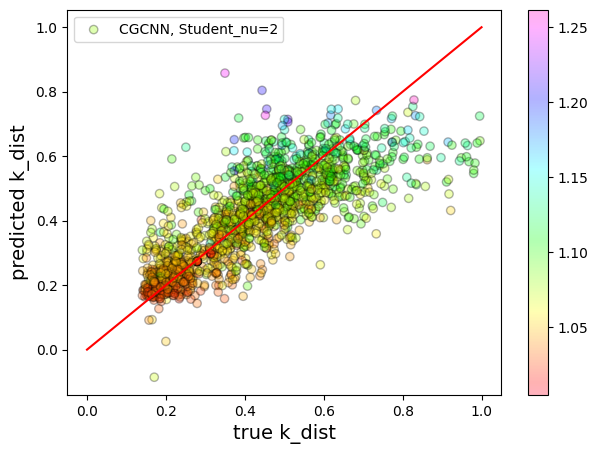

In [480]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, df['prediction'].values, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, Student_nu=2')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

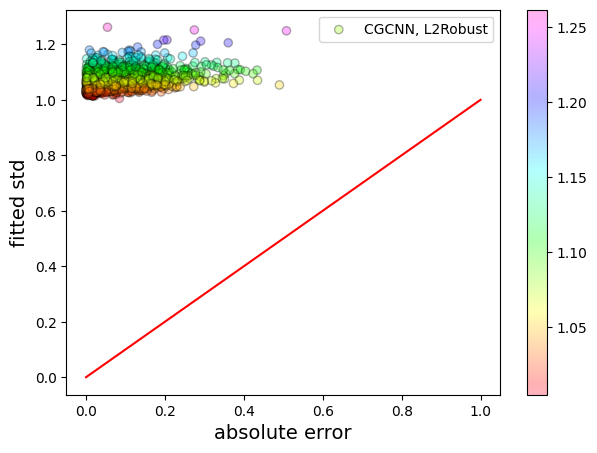

In [481]:
abs_errors=np.abs(df['truth'].values - df['prediction'].values)
scaled_std = std

plt.figure(figsize=(7,5))
sc=plt.scatter(abs_errors, scaled_std, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, L2Robust')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('absolute error', fontsize =14)
plt.ylabel('fitted std', fontsize = 14)
plt.legend()
plt.show()

In [482]:
from scipy import stats

test_bins=np.linspace(0.01,0.99,19)
test_bin_values=np.zeros(len(test_bins))
alphas=[]
scaled_std=[]
for jbin,x in enumerate(test_bins):
    test_covered=0
    for i in range(len(std)):
        scale = std[i]
        loc = df['prediction'].values[i]
        x1, x2 = stats.t.interval(x, df=5, loc=loc, scale=scale)
        if x1 < df['truth'].values[i] < x2:
            test_covered += 1
    test_bin_values[jbin] = test_covered / len(std)

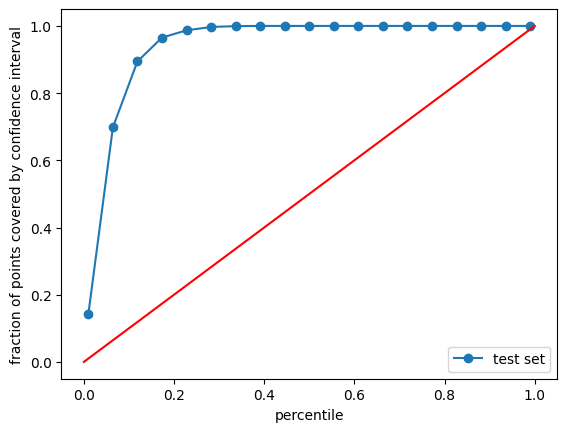

In [483]:
import matplotlib.pyplot as plt
plt.plot(test_bins,test_bin_values,'-o',label='test set')
plt.plot([0,1],[0,1],color='red')
plt.xlabel('percentile')
plt.ylabel('fraction of points covered by confidence interval')
plt.legend()
plt.show()

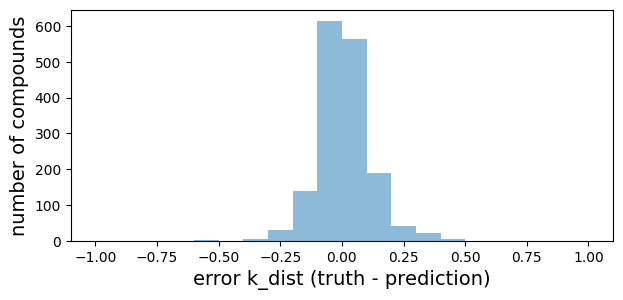

In [484]:
errors=df['truth'].values - df['prediction'].values

plt.figure(figsize=(7,3))
plt.hist(errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

In [375]:
shifted_predictions=[]
for i in range(len(df)):
    value=stats.t.interval(0.1, df=5, loc=df['prediction'].values[i], scale=std[i])[0]
    if(value<0.02):
        shifted_predictions.append(0.02)
    else:
        shifted_predictions.append(value)

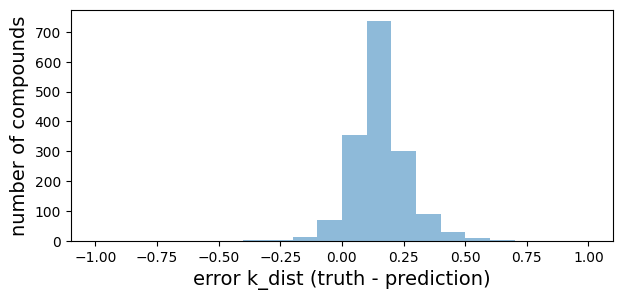

In [376]:
shifted_errors=df['truth'].values - shifted_predictions

plt.figure(figsize=(7,3))
plt.hist(shifted_errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

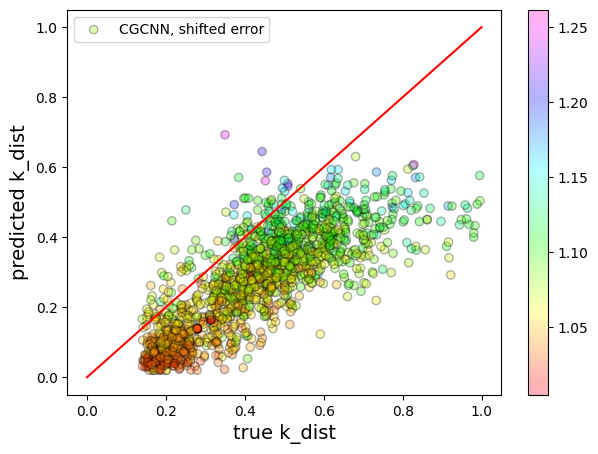

In [377]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, shifted_predictions, c=std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, shifted error')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

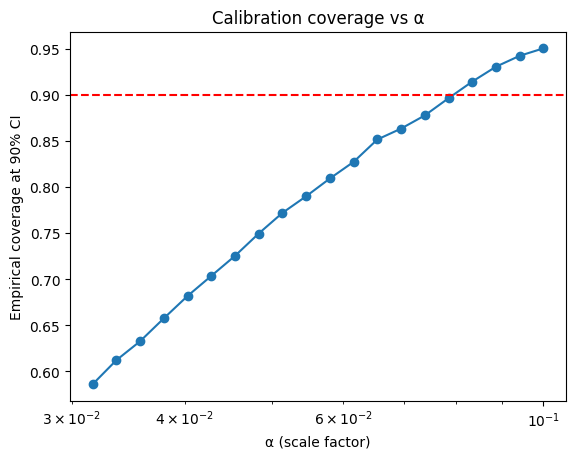

In [491]:
import matplotlib.pyplot as plt

alphas = np.logspace(-1.5, -1, 20)  # from 0.1 to 10
coverages = []

for alpha in alphas:
    scaled_std = alpha * np.exp(df['logstd0'].values)
    coverages_at_90 = []

    for i in range(len(df)):
        x1, x2 = stats.t.interval(0.9, df=5, loc=df['prediction'].values[i], scale=scaled_std[i])
        if x1 < df['truth'].values[i] < x2:
            coverages_at_90.append(1)
        else:
            coverages_at_90.append(0)

    coverages.append(np.mean(coverages_at_90))

plt.plot(alphas, coverages, marker='o')
plt.axhline(0.9, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel("α (scale factor)")
plt.ylabel("Empirical coverage at 90% CI")
plt.title("Calibration coverage vs α")
plt.show()


In [492]:
alphas[15], coverages[15]

(np.float64(0.07847599703514614), np.float64(0.8962088253573648))

In [493]:
scaled_std = alphas[15] * np.exp(df['logstd0'].values)

In [494]:
shifted_predictions=[]
for i in range(len(df)):
    value=stats.t.interval(0.9, df=5, loc=df['prediction'].values[i], scale=scaled_std[i])[0]
    if(value<0.02):
        shifted_predictions.append(0.02)
    else:
        shifted_predictions.append(value)

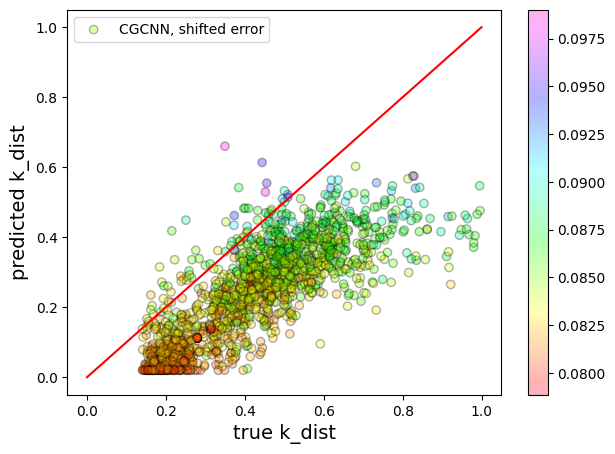

In [495]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, shifted_predictions, c=scaled_std,cmap='gist_rainbow', edgecolor='k', alpha=0.3, label='CGCNN, shifted error')
cbar = plt.colorbar(sc)
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

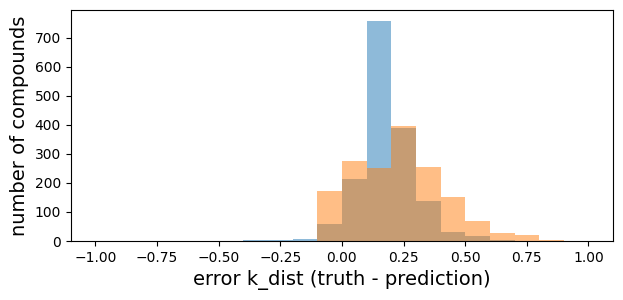

In [500]:
shifted_errors=df['truth'].values - shifted_predictions
dummy_errors=df['truth'].values-c_opt
neg_errors=[x for x in shifted_errors if x < 0]

plt.figure(figsize=(7,3))
plt.hist(shifted_errors, range=(-1,1), bins=20, alpha=0.5)
plt.hist(dummy_errors, range=(-1,1), bins=20, alpha=0.5)
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.show()

In [501]:
np.sum([shifted_errors<0]), np.sum([shifted_errors<0])/len(errors), np.sum([dummy_errors<0]), np.sum([dummy_errors<0])/len(dummy_errors),np.mean(neg_errors)

(np.int64(64),
 np.float64(0.039776258545680544),
 np.int64(173),
 np.float64(0.10752019888129273),
 np.float64(-0.05030928319599611))

In [502]:
mse = mean_squared_error(df['truth'].values, shifted_predictions)
mae = mean_absolute_error(df['truth'].values, shifted_predictions)
mape = mean_absolute_percentage_error(df['truth'].values, shifted_predictions)
r2 = r2_score(df['truth'].values, shifted_predictions)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.18310245729081184
Test set MAPE: 0.4639513533612954
Test set MSE: 0.04307949312229161
Test set R2 score: -0.4101914932050894


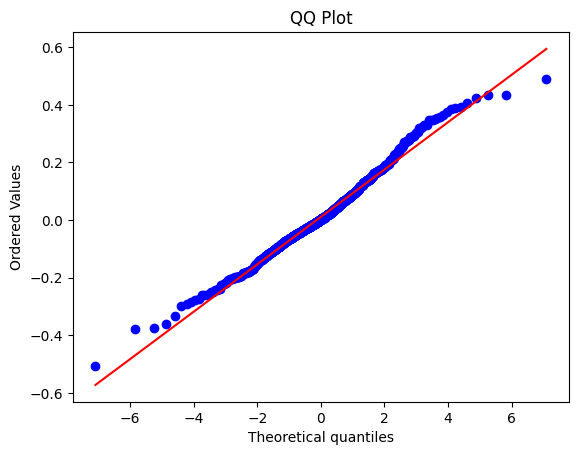

In [497]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# residuals: a numpy array or list of your model residuals
stats.probplot(errors, dist="t", sparams=(5,), plot=plt)  # change "norm" to "laplace" or "t" if needed
plt.title("QQ Plot")
plt.show()

# CGCNN, Quantile loss, q=0.1 quantile

In [399]:
output_file = "../output/cgcnn/cgcnn_basic_quantile_10.csv"

In [400]:
df=pd.read_csv(output_file)

In [413]:
df.head(3)

,Unnamed: 0,id,truth_scaled,prediction0,avg_prediction_scaled,prediction,truth
0,0,2678,0.381003,0.711772,0.711772,0.711772,0.381003
1,1,3919,0.247393,0.227477,0.227477,0.227477,0.247393
2,2,828,0.545084,0.480409,0.480409,0.480409,0.545084


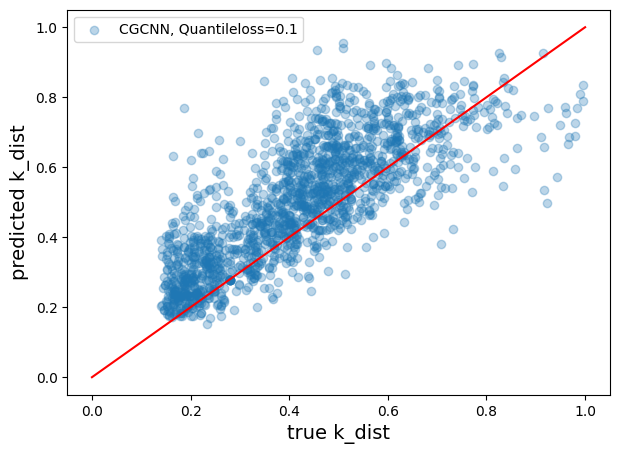

In [402]:
plt.figure(figsize=(7,5))
sc=plt.scatter(df['truth'].values, df['prediction'].values, alpha=0.3, label='CGCNN, Quantileloss=0.1')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

# CGCNN, Quantile loss, q=0.9 quantile

In [542]:
output_file = "../output/cgcnn/cgcnn_basic_quantile_90.csv"

In [543]:
df=pd.read_csv(output_file)

In [544]:
df.head(3)

,Unnamed: 0,id,truth_scaled,prediction0,avg_prediction_scaled,prediction,truth
0,0,2678,0.381003,0.364451,0.364451,0.364451,0.381003
1,1,3919,0.247393,0.190282,0.190282,0.190282,0.247393
2,2,828,0.545084,0.396633,0.396633,0.396633,0.545084


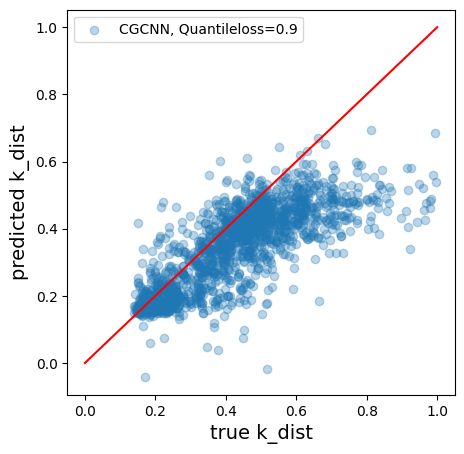

In [546]:
plt.figure(figsize=(5,5))
sc=plt.scatter(df['truth'].values, df['prediction'].values, alpha=0.3, label='CGCNN, Quantileloss=0.9')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

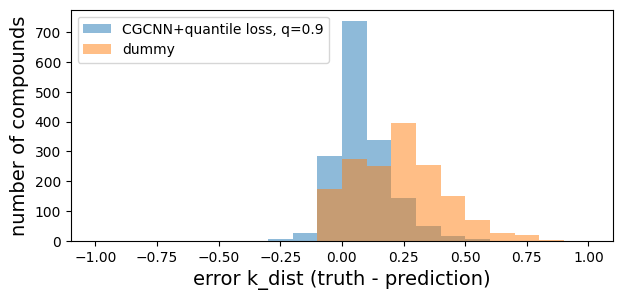

In [548]:
errors=df['truth'].values - df['prediction'].values
dummy_errors=df['truth'].values-c_opt
neg_errors=[x for x in errors if x < 0]

plt.figure(figsize=(7,3))
plt.hist(errors, range=(-1,1), bins=20, alpha=0.5, label='CGCNN+quantile loss, q=0.9')
plt.hist(dummy_errors, range=(-1,1), bins=20, alpha=0.5, label='dummy')
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.legend()
plt.show()

In [520]:
np.sum([errors<0]), np.sum([errors<0])/len(errors), np.sum([dummy_errors<0]), np.sum([dummy_errors<0])/len(dummy_errors),np.mean(neg_errors)

(np.int64(226),
 np.float64(0.14045991298943444),
 np.int64(173),
 np.float64(0.10752019888129273),
 np.float64(-0.03964837907079646))

In [521]:
np.mean(neg_errors)

np.float64(-0.03964837907079646)

In [522]:
mse = mean_squared_error(df['truth'].values, df['prediction'].values)
mae = mean_absolute_error(df['truth'].values, df['prediction'].values)
mape = mean_absolute_percentage_error(df['truth'].values, df['prediction'].values)
r2 = r2_score(df['truth'].values, df['prediction'].values)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.11318448051709136
Test set MAPE: 0.24462925299118585
Test set MSE: 0.02309546039132019
Test set R2 score: 0.24397852864610703


In [439]:
mse = mean_squared_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mae = mean_absolute_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
mape = mean_absolute_percentage_error(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
r2 = r2_score(df['truth'].values, c_opt*np.ones(len(df['truth'].values)))
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.2328592252025623
Test set MAPE: 0.46833731075132523
Test set MSE: 0.08241461457552567
Test set R2 score: -1.6978123456620682


# CGCNN, Quantile loss, q=0.9 quantile + lattice features

In [549]:
output_file = "../output/cgcnn/quantile_0.9_lattice_features.csv"

In [550]:
df=pd.read_csv(output_file)

In [551]:
df.head(3)

,Unnamed: 0,id,truth_scaled,prediction0,avg_prediction_scaled,prediction,truth
0,0,2678,0.381003,0.405737,0.405737,0.405737,0.381003
1,1,3919,0.247393,0.197178,0.197178,0.197178,0.247393
2,2,828,0.545084,0.456692,0.456692,0.456692,0.545084


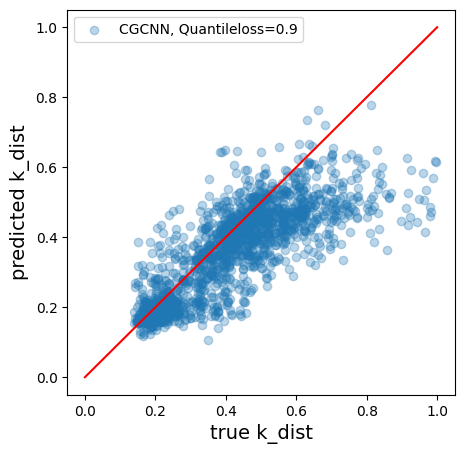

In [553]:
plt.figure(figsize=(5,5))
sc=plt.scatter(df['truth'].values, df['prediction'].values, alpha=0.3, label='CGCNN, Quantileloss=0.9')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('true k_dist', fontsize =14)
plt.ylabel('predicted k_dist', fontsize = 14)
plt.legend()
plt.show()

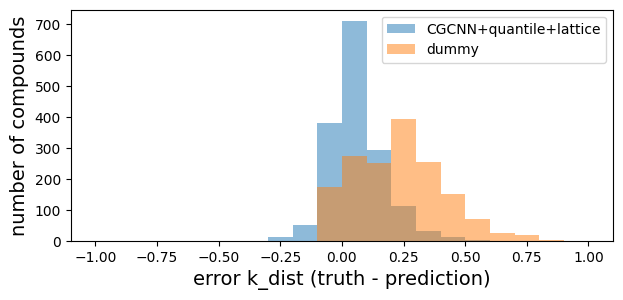

In [554]:
errors=df['truth'].values - df['prediction'].values
dummy_errors=df['truth'].values-c_opt
neg_errors=[x for x in errors if x < 0]

plt.figure(figsize=(7,3))
plt.hist(errors, range=(-1,1), bins=20, alpha=0.5,label='CGCNN+quantile+lattice')
plt.hist(dummy_errors, range=(-1,1), bins=20, alpha=0.5,label='dummy')
plt.xlabel('error k_dist (truth - prediction)', fontsize=14)
plt.ylabel('number of compounds', fontsize=14)
plt.legend()
plt.show()

In [536]:
np.sum([errors<0]), np.sum([errors<0])/len(errors), np.sum([dummy_errors<0]), np.sum([dummy_errors<0])/len(dummy_errors),np.mean(neg_errors)

(np.int64(443),
 np.float64(0.2753262896208825),
 np.int64(173),
 np.float64(0.10752019888129273),
 np.float64(-0.04814948636568849))

In [537]:
np.mean(neg_errors)

np.float64(-0.04814948636568849)

In [539]:
mse = mean_squared_error(df['truth'].values, df['prediction'].values)
mae = mean_absolute_error(df['truth'].values, df['prediction'].values)
mape = mean_absolute_percentage_error(df['truth'].values, df['prediction'].values)
r2 = r2_score(df['truth'].values, df['prediction'].values)
        
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')

Test set MAE: 0.08648909121814792
Test set MAPE: 0.19471488668212847
Test set MSE: 0.014954145132332187
Test set R2 score: 0.5104815139327397


# CGCNN, L1Robust, q=0.9 quantile + lattice features + swa

In [540]:
output_file = "../output/cgcnn/l1robust_lattice_features.csv"

In [541]:
df=pd.read_csv(output_file)

FileNotFoundError: [Errno 2] No such file or directory: '../output/cgcnn/l1robust_lattice_features.csv'